# TP1 MI204 - Features

CARVALHO FRULANE DE SOUZA Daniel 

GALVÃO Mateus

TAULOIS BRAGA Bernardo

## Format d'images et Convolutions

### Importation des librairies pertinentes

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable

### Lecture de l'image en niveau de gris et conversion en float64

(188, 478)
Dimension de l'image : 188 lignes x 478 colonnes


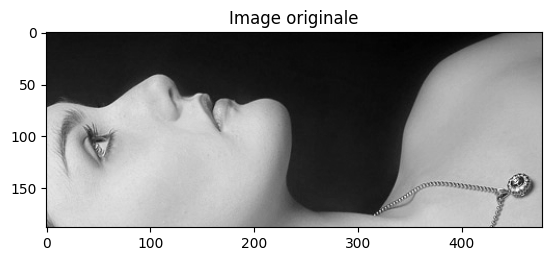

In [2]:
img=np.float64(cv2.imread('Image_Pairs/Face_profile0.jpg', cv2.IMREAD_GRAYSCALE))
print(img.shape)
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")

# affichage de l'image originale
plt.imshow(img, cmap='gray')
plt.title("Image originale")
plt.show()

### Méthode directe
Application d'un filtre du type sharpening de façon directe. On affiche l'image avec pyplot au lieu d'OpenCV à cause de sa compatibilité avec Jupyter. 

Méthode directe : 0.4449554 s


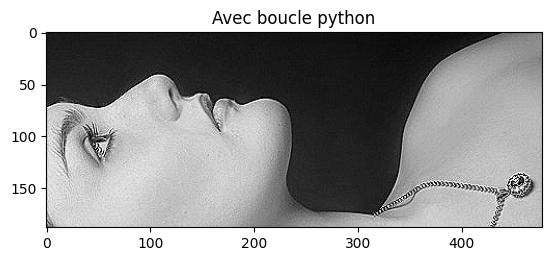

In [3]:
# début de la computation
t1 = cv2.getTickCount() 

# créer une borde autour de l'image
img2 = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)
for y in range(1,h-1):
  for x in range(1,w-1):
    # application du filtre
    val = 5*img[y, x] - img[y-1, x] - img[y, x-1] - img[y+1, x] - img[y, x+1] 
    img2[y,x] = min(max(val,0),255)

# fin de la computation
t2 = cv2.getTickCount()
time_direct = (t2 - t1)/ cv2.getTickFrequency()
print("Méthode directe :",time_direct,"s")

# affichage de l'image
plt.imshow(img2, cmap='gray')
plt.title("Avec boucle python")
plt.show()

### Méthode filter2D
Application d'une convolution 2D à l'image avec le kernel désiré. On utilise le kernel suivant :
$$
K = 
\begin{pmatrix}
0 & -1 & 0\\ 
-1 & 5 & -1 \\ 
0 & -1 & 0
\end{pmatrix}
$$
On utilise un poids de 5 pour la valeur centrale pour contribuer plus à la sortie. Les valeurs qui l'entournent ont un poids de $-1$ pour mettre en évidence les différences d'intentsité entre le pixel central et ses voisins. Cela entraîne une augmentation de la perception de contraste dans l'image.

Méthode filter2D : 0.0021584 s


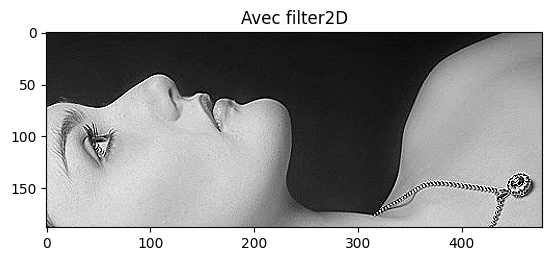

In [4]:
# début de la computation
t1 = cv2.getTickCount()

# définition du kernel et application de la convolution
kernel = np.array([[0, -1, 0],[-1, 5, -1],[0, -1, 0]])
img3 = cv2.filter2D(img,-1,kernel)

# fin de la computation
t2 = cv2.getTickCount()
time_filter2D = (t2 - t1)/ cv2.getTickFrequency()
print("Méthode filter2D :",time_filter2D,"s")

# affichage de l'image
plt.imshow(img3,cmap = 'gray',vmin = 0.0,vmax = 255.0)
plt.title("Avec filter2D")
plt.show()

### Comparaison entre les méthodes
On en observe que les méthodes ont des temps de calcul très différents, vu que la méthode filter2D est beaucoup plus rapide que la méthode directe. On peut en supposer que cela est dû au fait que la bibliothèque qui implémente cette fonction est capable de l'optimiser avec une implémentation plus efficace et la parallélisation, qu'on n'a pas utilisé dans la méthode directe.

La méthode filter2D est 206.15 fois plus rapide que la méthode directe.


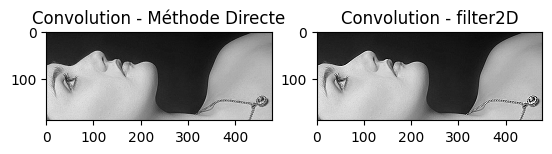

In [5]:
plt.subplot(121)
plt.imshow(img2,cmap = 'gray')
plt.title('Convolution - Méthode Directe')

plt.subplot(122)
plt.imshow(img3,cmap = 'gray',vmin = 0.0,vmax = 255.0)
plt.title('Convolution - filter2D')

print("La méthode filter2D est", "{:.2f}".format(time_direct / time_filter2D), "fois plus rapide que la méthode directe.")

### Gradient de l'image
Pour le calcul du gradient on a utilisé la fonction Sobel, qui compute une approximation du gradient d'une image. Cette fonction utilise un kernel pour calculer la variation de l'image par rapport à $x$ ou à $y$ : 
$$ G_x =
\begin{pmatrix}
-1 & 0 & 1\\ 
-2 & 0 & 2 \\ 
-1 & 0 & 1
\end{pmatrix}
, G_y = 
\begin{pmatrix}
-1 & -2 & -1\\ 
0 & 0 & 0 \\ 
1 & 2 & 1
\end{pmatrix}  $$
Pour bien visualiser les répresentations de $I_x$ et $I_y$, il faut utiliser un gradient de couleur capable de répresenter les valeurs négatives et positives. Ainsi, on a utilisé une échelle qui varie entre le bleu et le rouge centrée en zero.

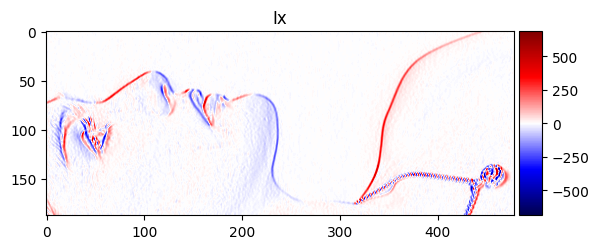

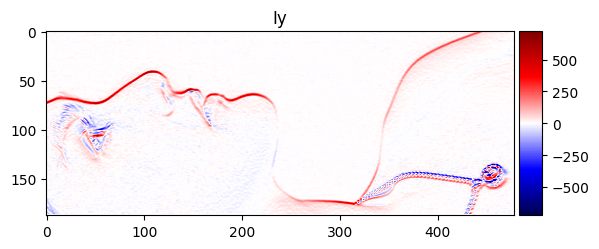

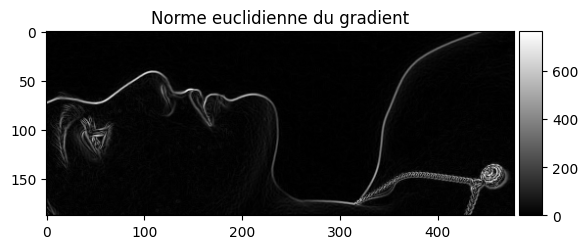

In [6]:
# computation des composants Ix et Iy du gradient
Ix = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=3)

# computation de la norme euclidienne du gradient
grad_norm = np.sqrt(Ix**2 + Iy**2)

# affichage des images
plt.title('Ix')
ax = plt.gca()
im = plt.imshow(Ix, norm=colors.CenteredNorm(), cmap='seismic')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

plt.title('Iy')
ax = plt.gca()
im = plt.imshow(Iy, norm=colors.CenteredNorm(), cmap='seismic')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

plt.title('Norme euclidienne du gradient')
ax = plt.gca()
im = ax.imshow(grad_norm, cmap='gray')
plt.colorbar(im, make_axes_locatable(ax).append_axes("right", size="5%", pad=0.05))
plt.show()

## Détecteurs

### Détecteur de Harris
On utilise alors un détecteur de Harris pour identifier les points d'intérêt, c'est-à-dire, les points angulaux dans une image. En effet, on cherche à identifier les points qui ont des valeurs propres importants. Dans ce contexte, on utilise une fonction basée sur la matrice d'autocorrelation d'un point quelconque donnée par :
$$\Theta_I (x,y) = \det \Xi_I (x,y) - \alpha\cdot\text{trace}^2 \Xi_I(x,y)$$
Cette matrice ne calcule pas explicitement les valeurs propres de $\Xi_I$, mais elle est capable d'identifier les points d'intérêt avec le choix du paramètre $\alpha$. Étant donné la matrice d'autocorrelation $\Xi_I$ prise dans un avoisinage du point $(x,y)$ :
$$
\Xi_I = 
\begin{pmatrix}
I_x^2 & I_xI_y \\ 
I_xI_y & I_y^2 \\ 
\end{pmatrix}
$$
On en obtient $\det\Xi_I = I_x^2I_y^2 - (I_xI_y)^2 $ et $\text{trace }\Xi_I = I_x^2 + I_y^2$

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [3]:
# lecture image en niveau de gris et conversion en float64
img=np.float64(cv2.imread('Image_Pairs/Graffiti0.png',cv2.IMREAD_GRAYSCALE))
(h,w) = img.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes")
print("Type de l'image :",img.dtype)

Dimension de l'image : 320 lignes x 400 colonnes
Type de l'image : float64


In [4]:
# début du calcul
t1 = cv2.getTickCount()
Theta = cv2.copyMakeBorder(img,0,0,0,0,cv2.BORDER_REPLICATE)

# fonction de Harris
Ix = cv2.Sobel(Theta, cv2.CV_64F, 1, 0, ksize=3)
Iy = cv2.Sobel(Theta, cv2.CV_64F, 0, 1, ksize=3)

Ix2 = Ix * Ix
Iy2 = Iy * Iy
Ixy = Ix * Iy

ksize = 5
sigma = 2
Ix2 = cv2.GaussianBlur(Ix2, (ksize, ksize), sigma)
Iy2 = cv2.GaussianBlur(Iy2, (ksize, ksize), sigma)
Ixy = cv2.GaussianBlur(Ixy, (ksize, ksize), sigma)

det_M = Ix2 * Iy2 - Ixy**2
trace_M = Ix2 + Iy2

k = 0.1
Theta = det_M - k * (trace_M**2)

# calcul des maxima locaux et seuillage
Theta_maxloc = cv2.copyMakeBorder(Theta,0,0,0,0,cv2.BORDER_REPLICATE)
d_maxloc = 3
seuil_relatif = 0.04
se = np.ones((d_maxloc,d_maxloc),np.uint8)
Theta_dil = cv2.dilate(Theta,se)

#Suppression des non-maxima-locaux
Theta_maxloc[Theta < Theta_dil] = 0.0

#On néglige également les valeurs trop faibles
Theta_maxloc[Theta < seuil_relatif*Theta.max()] = 0.0

# fin du calcul
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Mon calcul des points de Harris :",time,"s")
print("Nombre de cycles par pixel :",(t2 - t1)/(h*w),"cpp")

Mon calcul des points de Harris : 0.0132269 s
Nombre de cycles par pixel : 103.33515625 cpp


In [23]:
se_croix = np.uint8([[1, 0, 0, 0, 1],
[0, 1, 0, 1, 0],[0, 0, 1, 0, 0],
[0, 1, 0, 1, 0],[1, 0, 0, 0, 1]])
Theta_ml_dil = cv2.dilate(Theta_maxloc,se_croix)

#Relecture image pour affichage couleur
Img_pts=cv2.imread('Image_Pairs/Graffiti0.png',cv2.IMREAD_COLOR)
(h,w,c) = Img_pts.shape
print("Dimension de l'image :",h,"lignes x",w,"colonnes x",c,"canaux")
print("Type de l'image :",Img_pts.dtype)

#On affiche les points (croix) en rouge
Img_pts[Theta_ml_dil > 0] = [255,0,0]

Dimension de l'image : 320 lignes x 400 colonnes x 3 canaux
Type de l'image : uint8


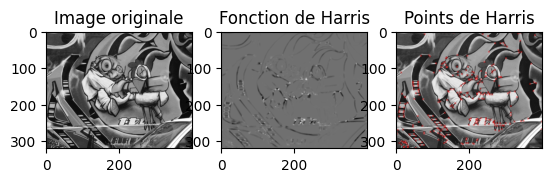

In [24]:
# affichage des images
plt.subplot(131)
plt.imshow(img,cmap = 'gray')
plt.title('Image originale')

plt.subplot(132)
plt.imshow(Theta,cmap = 'gray')
plt.title('Fonction de Harris')

plt.subplot(133)
plt.imshow(Img_pts, cmap='gray')
plt.title('Points de Harris')

plt.show()

### Détecteurs ORB et KAZE

In [3]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys

#Lecture de la paire d'images
img1 = cv2.imread('../Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('../Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8


Détection des points d'intérêt : 0.0078065 s


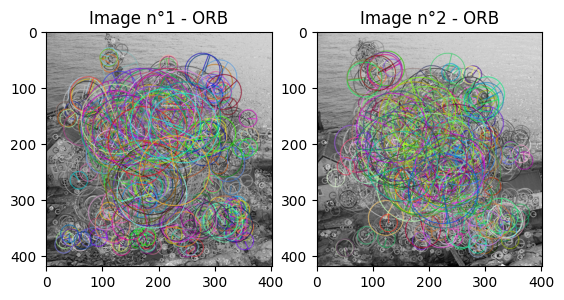

In [26]:
# Détecteur ORB
t1 = cv2.getTickCount()

kp1 = cv2.ORB_create(nfeatures = 250,#Par défaut : 500
                      scaleFactor = 2,#Par défaut : 1.2
                      nlevels = 3)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=250,
                      scaleFactor = 2,
                      nlevels = 3)

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1_ORB = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2_ORB = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1_ORB)
plt.title('Image n°1 - ORB')

plt.subplot(122)
plt.imshow(img2_ORB)
plt.title('Image n°2 - ORB')

plt.show()

Détection des points d'intérêt : 65.451123 s


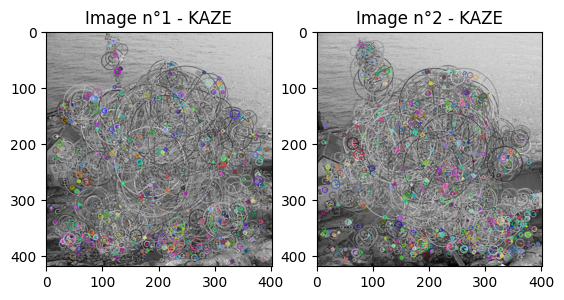

In [27]:
# Détecteur KAZE
kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
                threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
            threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection des keypoints
pts1 = kp1.detect(gray1,None)
pts2 = kp2.detect(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection des points d'intérêt :",time,"s")

#Affichage des keypoints
img1_KAZE = cv2.drawKeypoints(gray1, pts1, None, flags=4)
# flags définit le niveau d'information sur les points d'intérêt
# 0 : position seule ; 4 : position + échelle + direction
img2_KAZE = cv2.drawKeypoints(gray2, pts2, None, flags=4)

plt.subplot(121)
plt.imshow(img1_KAZE)
plt.title('Image n°1 - KAZE')

plt.subplot(122)
plt.imshow(img2_KAZE)
plt.title('Image n°2 - KAZE')

plt.show()

Text(0.5, 1.0, 'Image n°2 - KAZE')

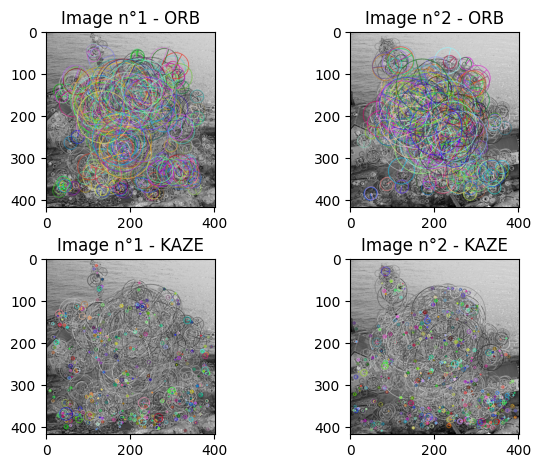

In [25]:
# Comparaison entre les détecteurs ORB et KAZE
plt.subplot(221)
plt.imshow(img1_ORB)
plt.title('Image n°1 - ORB')

plt.subplot(222)
plt.imshow(img2_ORB)
plt.title('Image n°2 - ORB')

plt.tight_layout(pad=2)

plt.subplot(223)
plt.imshow(img1_KAZE)
plt.title('Image n°1 - KAZE')

plt.subplot(224)
plt.imshow(img2_KAZE)
plt.title('Image n°2 - KAZE')

## Descripteurs et Appariement

Pour le prochain cas, trois stratégies différentes d’appariement de points d’intérêt seront comparées à l'aide des scripts Features_Match_CrossCheck.py, Features_Match_RatioTest.py et Features_Match_FLANN.py. Les codes et les résultats obtenus sont ensuite affichés.

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
import sys

Feature matching Cross Check

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8

Détecteur : ORB
Détection points et calcul descripteurs : 0.0131844 s
Calcul de l'appariement : 0.003417 s


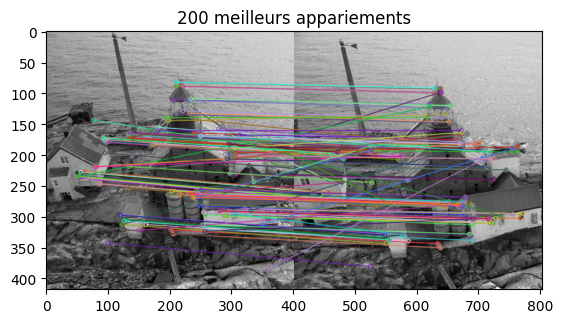

Détecteur : KAZE
Détection points et calcul descripteurs : 0.3088765 s
Calcul de l'appariement : 0.0045009 s


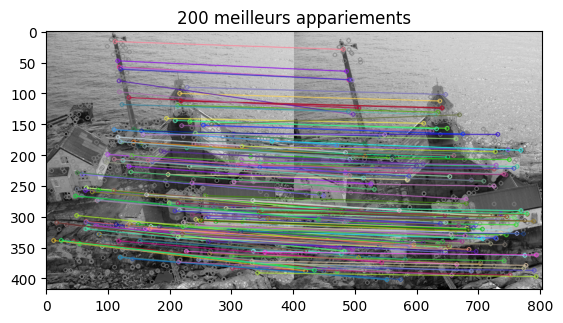

In [16]:
print("Feature matching Cross Check\n")

#Lecture de la paire d'images
img1 = cv2.imread('../Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('../Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 1
kp1 = cv2.ORB_create(nfeatures = 500,#Par défaut : 500
                scaleFactor = 1.2,#Par défaut : 1.2
                nlevels = 8)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=500,
                scaleFactor = 1.2,
                nlevels = 8)
print("\nDétecteur : ORB")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
#Les points non appariés apparaîtront en gris 
img1 = cv2.drawKeypoints(gray1, pts1, None, color=(127,127,127), flags=0)
img2 = cv2.drawKeypoints(gray2, pts2, None, color=(127,127,127), flags=0)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
if detector == 1:
  #Distance de Hamming pour descripteur BRIEF (ORB)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
else:
  #Distance L2 pour descripteur M-SURF (KAZE)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc1,desc2)
# Tri des appariemements 
matches = sorted(matches, key = lambda x:x.distance)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Trace les N meilleurs appariements
Nbest = 200
img3 = cv2.drawMatches(img1,pts1,img2,pts2,matches[:Nbest],None,flags=2)
plt.imshow(img3),plt.title('%i meilleurs appariements'%Nbest)
plt.show()


#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 2
kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
            threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
            threshold = 0.001,#Par défaut : 0.001
            nOctaves = 4,#Par défaut : 4
            nOctaveLayers = 4,#Par défaut : 4
            diffusivity = 2)#Par défaut : 2
print("Détecteur : KAZE")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
#Les points non appariés apparaîtront en gris 
img1 = cv2.drawKeypoints(gray1, pts1, None, color=(127,127,127), flags=0)
img2 = cv2.drawKeypoints(gray2, pts2, None, color=(127,127,127), flags=0)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
if detector == 1:
  #Distance de Hamming pour descripteur BRIEF (ORB)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
else:
  #Distance L2 pour descripteur M-SURF (KAZE)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = bf.match(desc1,desc2)
# Tri des appariemements 
matches = sorted(matches, key = lambda x:x.distance)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Trace les N meilleurs appariements
Nbest = 200
img3 = cv2.drawMatches(img1,pts1,img2,pts2,matches[:Nbest],None,flags=2)
plt.imshow(img3),plt.title('%i meilleurs appariements'%Nbest)
plt.show()

Feature matching Ratio Test

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8

Détecteur : ORB
Détection points et calcul descripteurs : 0.0114314 s
Calcul de l'appariement : 0.0056284 s


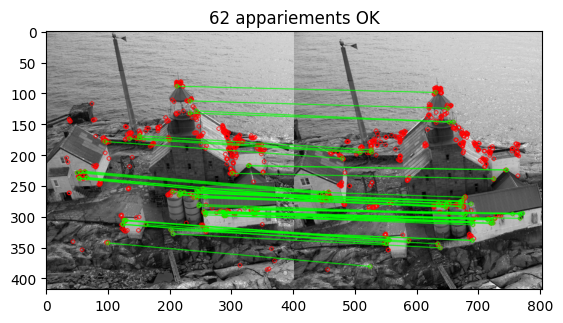

Détecteur : KAZE
Détection points et calcul descripteurs : 0.3462682 s
Calcul de l'appariement : 0.0031303 s


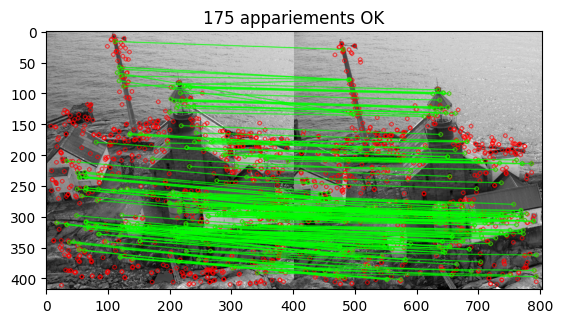

In [20]:
print("Feature matching Ratio Test\n")

#Lecture de la paire d'images
img1 = cv2.imread('../Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('../Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 1
kp1 = cv2.ORB_create(nfeatures = 500,#Par défaut : 500
                    scaleFactor = 1.2,#Par défaut : 1.2
                    nlevels = 8)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=500,
                    scaleFactor = 1.2,
                    nlevels = 8)
print("\nDétecteur : ORB")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
if detector == 1:
  #Distance de Hamming pour descripteur BRIEF (ORB)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
  #Distance L2 pour descripteur M-SURF (KAZE)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# Extraction de la liste des 2-plus-proches-voisins
matches = bf.knnMatch(desc1,desc2, k=2)
# Application du ratio test
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance:
    good.append([m])
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Affichage des appariements qui respectent le ratio test
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)
img3 = cv2.drawMatchesKnn(gray1,pts1,gray2,pts2,good,None,**draw_params)

Nb_ok = len(good)
plt.imshow(img3),plt.title('%i appariements OK'%Nb_ok)
plt.show()



#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 2
kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
                    threshold = 0.001,#Par défaut : 0.001
                    nOctaves = 4,#Par défaut : 4
                    nOctaveLayers = 4,#Par défaut : 4
                    diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
                    threshold = 0.001,#Par défaut : 0.001
                    nOctaves = 4,#Par défaut : 4
                    nOctaveLayers = 4,#Par défaut : 4
                    diffusivity = 2)#Par défaut : 2
print("Détecteur : KAZE")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
if detector == 1:
  #Distance de Hamming pour descripteur BRIEF (ORB)
  bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=False)
else:
  #Distance L2 pour descripteur M-SURF (KAZE)
  bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
# Extraction de la liste des 2-plus-proches-voisins
matches = bf.knnMatch(desc1,desc2, k=2)
# Application du ratio test
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance:
    good.append([m])
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Affichage des appariements qui respectent le ratio test
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)
img3 = cv2.drawMatchesKnn(gray1,pts1,gray2,pts2,good,None,**draw_params)

Nb_ok = len(good)
plt.imshow(img3),plt.title('%i appariements OK'%Nb_ok)
plt.show()

Feature matching FLANN

Dimension de l'image 1 : 418 lignes x 402 colonnes
Type de l'image 1 : uint8
Dimension de l'image 2 : 418 lignes x 402 colonnes
Type de l'image 2 : uint8

Détecteur : ORB
Détection points et calcul descripteurs : 0.0112621 s
Calcul de l'appariement : 0.0074868 s


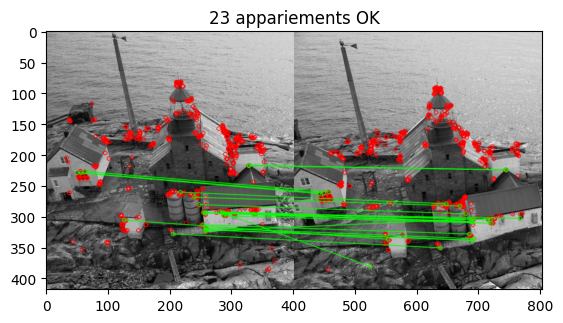

Détecteur : KAZE
Détection points et calcul descripteurs : 0.378134 s
Calcul de l'appariement : 0.0272202 s


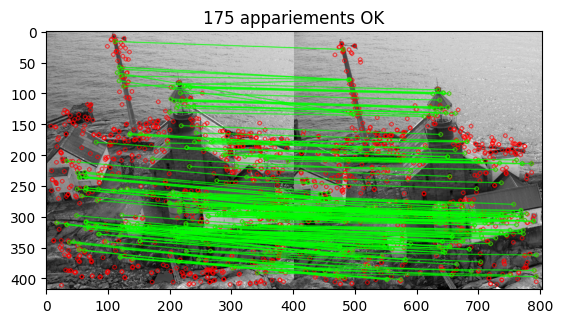

In [22]:
print("Feature matching FLANN\n")

#Lecture de la paire d'images
img1 = cv2.imread('../Image_Pairs/torb_small1.png')
print("Dimension de l'image 1 :",img1.shape[0],"lignes x",img1.shape[1],"colonnes")
print("Type de l'image 1 :",img1.dtype)
img2 = cv2.imread('../Image_Pairs/torb_small2.png')
print("Dimension de l'image 2 :",img2.shape[0],"lignes x",img2.shape[1],"colonnes")
print("Type de l'image 2 :",img2.dtype)

#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 1
kp1 = cv2.ORB_create(nfeatures = 500,#Par défaut : 500
                    scaleFactor = 1.2,#Par défaut : 1.2
                    nlevels = 8)#Par défaut : 8
kp2 = cv2.ORB_create(nfeatures=500,
                    scaleFactor = 1.2,
                    nlevels = 8)
print("\nDétecteur : ORB")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
desc1 = np.float32(desc1)
desc2 = np.float32(desc2)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
# Paramètres de FLANN 
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(desc1,desc2,k=2)
# Application du ratio test
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance:
    good.append([m])
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Affichage
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)

# Affichage des appariements qui respectent le ratio test
img3 = cv2.drawMatchesKnn(gray1,pts1,gray2,pts2,good,None,**draw_params)

Nb_ok = len(good)
plt.imshow(img3),plt.title('%i appariements OK'%Nb_ok)
plt.show()



#Début du calcul
t1 = cv2.getTickCount()
#Création des objets "keypoints"
detector = 2
kp1 = cv2.KAZE_create(upright = False,#Par défaut : false
                    threshold = 0.001,#Par défaut : 0.001
                    nOctaves = 4,#Par défaut : 4
                    nOctaveLayers = 4,#Par défaut : 4
                    diffusivity = 2)#Par défaut : 2
kp2 = cv2.KAZE_create(upright = False,#Par défaut : false
                    threshold = 0.001,#Par défaut : 0.001
                    nOctaves = 4,#Par défaut : 4
                    nOctaveLayers = 4,#Par défaut : 4
                    diffusivity = 2)#Par défaut : 2
print("Détecteur : KAZE")

#Conversion en niveau de gris
gray1 =  cv2.cvtColor(img1,cv2.COLOR_BGR2GRAY)
gray2 =  cv2.cvtColor(img2,cv2.COLOR_BGR2GRAY)
#Détection et description des keypoints
pts1, desc1 = kp1.detectAndCompute(gray1,None)
pts2, desc2 = kp2.detectAndCompute(gray2,None)
desc1 = np.float32(desc1)
desc2 = np.float32(desc2)
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Détection points et calcul descripteurs :",time,"s")
# Calcul de l'appariement
t1 = cv2.getTickCount()
# Paramètres de FLANN 
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) 

flann = cv2.FlannBasedMatcher(index_params,search_params)

matches = flann.knnMatch(desc1,desc2,k=2)
# Application du ratio test
good = []
for m,n in matches:
  if m.distance < 0.7*n.distance:
    good.append([m])
t2 = cv2.getTickCount()
time = (t2 - t1)/ cv2.getTickFrequency()
print("Calcul de l'appariement :",time,"s")

# Affichage
draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   flags = 0)

# Affichage des appariements qui respectent le ratio test
img3 = cv2.drawMatchesKnn(gray1,pts1,gray2,pts2,good,None,**draw_params)

Nb_ok = len(good)
plt.imshow(img3),plt.title('%i appariements OK'%Nb_ok)
plt.show()

Avant d'analyser les résultats, il est important de comprendre chacune des stratégies utilisées.

La première stratégie est le "Feature Match Cross Check". Dans cette approche, les descripteurs des deux images sont comparés directement, sans tenir compte de la correspondance des points d'une image à l'autre. La méthode `cv2.BFMatcher()` est utilisée avec le paramètre `crossCheck=True`, ce qui signifie que l'algorithme vérifie la correspondance des points dans les deux sens (de l'image 1 à l'image 2 et vice versa), ce qui peut potentiellement augmenter le temps de traitement mais améliorer la précision.

La deuxième stratégie est le "Feature Match Ratio Test". Ici, les descripteurs des deux images sont également comparés, mais un test de ratio est appliqué pour filtrer les correspondances. Ce test aide à éliminer les correspondances ambiguës en ne considérant que celles dont la distance est significativement plus petite que la deuxième meilleure correspondance. La méthode `bf.knnMatch()` est utilisée pour trouver les deux descripteurs les plus proches, puis le test de ratio est appliqué pour sélectionner les correspondances valides.

La troisième stratégie est le "Feature Match FLANN". Dans cette approche, les descripteurs de points d'intérêt des images sont comparés en utilisant un arbre KD (arbre de recherche binaire multidimensionnel) pour trouver des correspondances approximatives. Cette approche basée sur l'indexation rend le processus de correspondance plus rapide par rapport aux méthodes de force brute.

En analysant les performances qualitativement, on peut remplir le tableau suivante avec les temps détection de points et calcul de descripteurs:

| Tems de calcul [s] | Cross Check | Ratio Test | FLANN     |
|:------------------:|:-----------:|:----------:|:---------:|
|   ORB              | 0.0131844   |  0.0114314 | 0.0112621 |
|   KAZE             | 0.3088765   |  0.3462682 | 0.378134  |

Avec cess données, on peut faire des analyses:

- Pour l'ORB, la stratégie "Feature Match FLANN" présente un temps de détection de points et de calcul de descripteurs plus rapide par rapport au "Feature Match Cross Check" et au "Feature Match Ratio Test". La combinaison de l'ORB avec le FLANN pour effectuer des correspondances de caractéristiques peut être plus rapide que d'autres stratégies en raison de l'efficacité du FLANN à trouver des voisins les plus proches dans des ensembles de données grands et de haute dimensionnalité. Le FLANN peut traiter rapidement et efficacement les descripteurs binaires générés par l'ORB, ce qui se traduit par un temps de calcul plus court pour la correspondance des caractéristiques. Il faut dire que le code "Features Match FLANN" ne fonctionnait pas pour l'ORB, mais changer le type des variables desc1 et desc2 en float permettait de générer les images et de faire les calculs.

- En revanche, pour le KAZE, le temps de détection de points et de calcul de descripteurs a été plus rapide pour le "Feature Match Cross Check". Cela peut être dû au fait que le KAZE est un descripteur plus complexe et robuste, nécessitant plus de temps de traitement si la stratégie est aussi plus complexe, mais on peut voir que la stratégie "Feature Match Cross Check" a fait plusiers erreurs apparentes.

Quant aux distances utilisées pour chaque type de descripteur :

- Pour les descripteurs ORB, la distance de Hamming est utilisée, une métrique spécifique pour les descripteurs binaires. Cela est dû au fait que l'ORB génère des descripteurs binaires de taille fixe, et la distance de Hamming est efficace pour les comparer.

- En revanche, pour les descripteurs KAZE, la distance L2 (euclidienne) est utilisée, plus couramment employée pour comparer des vecteurs de caractéristiques. Le KAZE génère des descripteurs vectoriels qui représentent l'intensité de l'image à différentes échelles et orientations, ce qui rend la distance L2 le choix approprié pour comparer ces vecteurs.


Une méthode pour évaluer de manière quantitative la qualité des appariements en déformant une image avec une transformation géométrique connue peut être la suivante:

Tout d'abord, il est nécessaire de générer un ensemble de correspondances de référence entre les points d'intérêt des deux images avant de procéder à la déformation. Ces correspondances serviront de base pour évaluer la qualité des appariements après déformation. Cela peut être réalisé en utilisant des stratégies de correspondance telles que le "Feature Match Cross Check" ou le "Feature Match Ratio Test".

Ensuite, une des images est déformée en utilisant une transformation géométrique connue, comme celle fournie par la fonction cv2.warpAffine. Cette transformation peut comprendre des translations, des rotations, des mises à l'échelle ou des distorsions plus complexes selon les besoins de l'évaluation.

Une fois l'image déformée, les mêmes descripteurs et stratégies de correspondance sont utilisés pour trouver de nouveaux appariements entre les deux images.

Les nouvelles correspondances obtenues sont ensuite comparées aux correspondances de référence. Cette comparaison peut se faire en utilisant diverses métriques telles que le nombre de correspondances correctement identifiées, le pourcentage de correspondances correctes par rapport au total des correspondances, ou des mesures plus sophistiquées comme la précision, le rappel ou le F-score.

Enfin, les résultats obtenus sont analysés pour évaluer la performance de l'algorithme de correspondance après déformation. Cela permettra de déterminer dans quelle mesure l'algorithme est robuste aux transformations géométriques et s'il est nécessaire d'apporter des ajustements pour améliorer sa performance dans de telles situations.